In [129]:

# Import packages
import pandas as pd
import atom as atom
from atom import ATOMRegressor
import sklearn as sk
import gplearn as gp
from gplearn.genetic import SymbolicTransformer,SymbolicRegressor


In [152]:
# Load data
X = pd.read_csv("OriginalData.csv")

# Checking how it looks like 
X.head()

# if we want to see the full dataframe... 
# pd.set_option('display.max_rows',500)





,Formula,M,X,T,Workfunction,HoF,E_Hull,Length(x),r-(M),r-(X),r-(T),IP(M),IP(X),IP(T),EN(M),EN(X),EN(T),EA(M),EA(X),EA(T)
0,Hf3C2H2O2,Hf,C,OH,2.271378,-1.345952,0.242880,330.4,82.9,59.6,41.4,6.8250,11.2603,13.017,1.30,2.55,2.82,0.178,1.262,1.827
1,Sc3C2H2O2,Sc,C,OH,1.588009,-1.199954,0.452744,335.0,53.9,59.6,41.4,6.5614,11.2603,13.017,1.36,2.55,2.82,0.189,1.262,1.827
2,W3C2H2O2,W,C,OH,2.209840,-0.317344,0.473693,290.6,74.6,59.6,41.4,7.9800,11.2603,13.017,2.36,2.55,2.82,0.816,1.262,1.827
3,Mo3H2N2O2,Mo,N,OH,2.463148,-0.594739,0.327053,285.0,70.2,48.8,41.4,7.0942,14.5341,13.017,2.16,3.04,2.82,0.749,-0.070,1.827
4,Ti3H2N2O2,Ti,N,OH,2.329750,-1.597694,0.163033,298.9,48.9,48.8,41.4,6.8282,14.5341,13.017,1.54,3.04,2.82,0.087,-0.070,1.827


In [153]:
#dropping formula as it's not needed for either classification nor regression. 
X.drop(['Formula'],axis=1,inplace=True)

In [155]:
# Initialize atom 
atom = ATOMRegressor(X, "Workfunction",verbose=2, warnings=False,random_state=42) 
#test_size by default is 0.2. 
#verbose=2. Increase verbosity to see produce more logging output (see more detail of what the model is producing )



<< ================== ATOM ================== >>
Algorithm task: regression.

Dataset stats ==================== >>
Shape: (315, 19)
Memory: 95.64 kB
Scaled: False
Missing values: 80 (1.3%)
Categorical features: 3 (16.7%)
Outlier values: 2 (0.0%)
-------------------------------------
Train set size: 252
Test set size: 63



In [156]:
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8) #replacing the NaN E-Hull and Hof values using KNN
atom.encode(max_onehot=10, frac_to_other=0.04) #encoding the classified elements (M,X,T)

Fitting Imputer...
Imputing missing values...
 --> Imputing 40 missing values using the KNN imputer in feature HoF.
 --> Imputing 40 missing values using the KNN imputer in feature E_Hull.
Fitting Encoder...
Encoding categorical columns...
 --> LeaveOneOut-encoding feature M. Contains 12 classes.
 --> Ordinal-encoding feature X. Contains 2 classes.
 --> LeaveOneOut-encoding feature T. Contains 20 classes.


In [77]:
atom.scale(strategy="standard")
#default is standard. removing mean and scaling to unit variance. 

Fitting Scaler...
Scaling features...


In [78]:
#prune replacing or removing outliers. 
atom.prune(strategy="zscore",max_sigma=4, include_target=True)
#maximum acceptable st. deviation 
#other strategies : "iforest","ee","lof","svm","dbscan,"optics"
#which is the best strategy method? is it right to replace outlier like this? what are the chemical significance of these outliers? 

Pruning outliers...
 --> Dropping 0 outliers.


In [79]:
#other cleaning methods that were not used here: Gauss, balancer (alance the number of samples per class in target column)

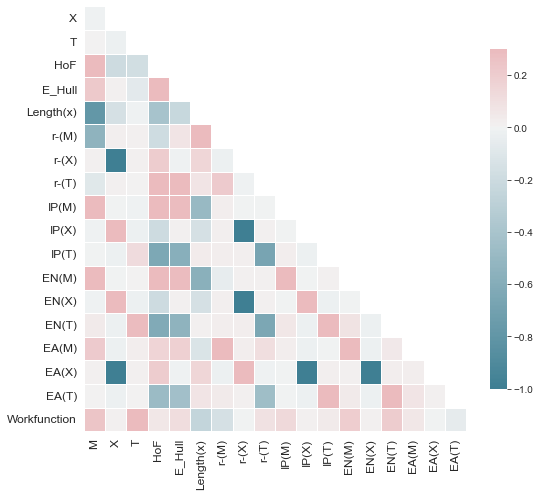

In [80]:
atom.plot_correlation()

In [81]:
# Conduct LightGBM model to see its performance before feature engineering. (or are other models like CNN better)
atom.run('LGB')



Training ========================= >>
Models: LGB
Metric: r2


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> r2: 0.976
Test evaluation --> r2: 0.9351
Time elapsed: 0.093s
-------------------------------------------------
Total time: 0.093s


Final results ==================== >>
Duration: 0.098s
-------------------------------------
LightGBM --> r2: 0.9351


In [82]:
# more information about LGB 

# Feature generation (two types: Deep Feature Synthesis, Genetic Feature Generation) 

In [83]:
#these two, if i understand correctly, are iterative improvement methods. i should try out the brute force ones, just in case iterative improvement methods miss out important information. 

# Deep Feature Synthesis


In [84]:
# Since we are going to compare different datasets,
## why are we comparing different datasets? 
# we need to create separate branches
atom.branch = "dfss"

New branch dfss successfully created.


In [ ]:
# somewhere here, i need to add to make sure the feature generated makes physical sense. use generic autofeat/ Sympy Python library, Pint Python library. 

In [86]:
# Create 50 new features using dfs
atom.feature_generation("dfs", verbose = 2)
#by default uses all operators. , operators=["add", "sub", "log", "mul","div","sqrt","sin","cos","tan"]
#by default no limit in number of features , n_features= None
#genetic programming symbolic transformer. optionally need **kwargs. 
#read more about this genetic programming thing. 

Fitting FeatureGenerator...
Creating new features...
 --> 873 new features were added.


In [87]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 40 missing values using the KNN imputer in feature EA(M) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EA(M) / HoF.
 --> Imputing 40 missing values using the KNN imputer in feature EA(T) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EA(T) / HoF.
 --> Imputing 40 missing values using the KNN imputer in feature EA(X) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EA(X) / HoF.
 --> Imputing 40 missing values using the KNN imputer in feature EN(M) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EN(M) / HoF.
 --> Imputing 40 missing values using the KNN imputer in feature EN(T) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EN(T) / HoF.
 --> Imputing 40 missing values using the KNN imputer in feature EN(X) / E_Hull.
 --> Imputing 40 missing values using the KNN imputer in feature EN(X) / HoF.


In [88]:
# checking multicollinearity and use rfecv to reduce the number. multicollinearity: when the independent variables are correlated. rfecv: recursive feature elimination with cross validation. 
# checking for low variance features. 
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=50,
    #scoring="auc",
    max_correlation=0.80,
)
#need to adjust these parameters as well! 


Fitting FeatureSelector...
Performing feature selection ...
 --> Feature EN(X) - IP(X) was removed due to low variance. Value -1.3322676295501878e-15 repeated in 100.0% of the rows.
 --> Feature NATURAL_LOGARITHM(EA(X)) was removed due to low variance. Value 0.023814024494627165 repeated in 100.0% of the rows.
 --> Feature NATURAL_LOGARITHM(X) was removed due to low variance. Value -0.023814024494627287 repeated in 100.0% of the rows.
 --> Feature NATURAL_LOGARITHM(r-(X)) was removed due to low variance. Value 0.023814024494626298 repeated in 100.0% of the rows.
 --> Feature SQUARE_ROOT(EA(X)) was removed due to low variance. Value 1.0119781829137982 repeated in 100.0% of the rows.
 --> Feature SQUARE_ROOT(r-(X)) was removed due to low variance. Value 1.0119781829137977 repeated in 100.0% of the rows.
 --> Feature IP(X) was removed due to collinearity with another feature.
 --> Feature EN(X) was removed due to collinearity with another feature.
 --> Feature EN(T) was removed due to col

In [89]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,IP(X),"X, r-(X)","1.0, -1.0"
1,EN(X),"X, r-(X), IP(X)","1.0, -1.0, 1.0"
2,EN(T),IP(T),0.95844
3,EA(X),"X, r-(X), IP(X), EN(X)","-1.0, 1.0, -1.0, -1.0"
4,ABSOLUTE(EA(X)),"X, r-(X), IP(X), EN(X), EA(X)","-1.0, 1.0, -1.0, -1.0, 1.0"
...,...,...,...
568,r-(X) / M,"EA(X) / EN(M), EA(X) / M, EN(X) / EN(M), EN(X)...","0.91595, 1.0, -0.91595, -1.0, -0.91595, -1.0, ..."
569,r-(X) / T,"EA(X) / T, EN(X) / T, IP(X) / T, X / T","1.0, -1.0, -1.0, -1.0"
570,r-(X) / X,"X, r-(X), IP(X), EN(X), EA(X), ABSOLUTE(EA(X))...","-1.00025, 1.00025, -1.00025, -1.00025, 1.00025..."
571,r-(X) / r-(M),"EA(X) / r-(M), EN(X) / r-(M), IP(X) / r-(M), X...","1.0, -1.0, -1.0, -1.0"


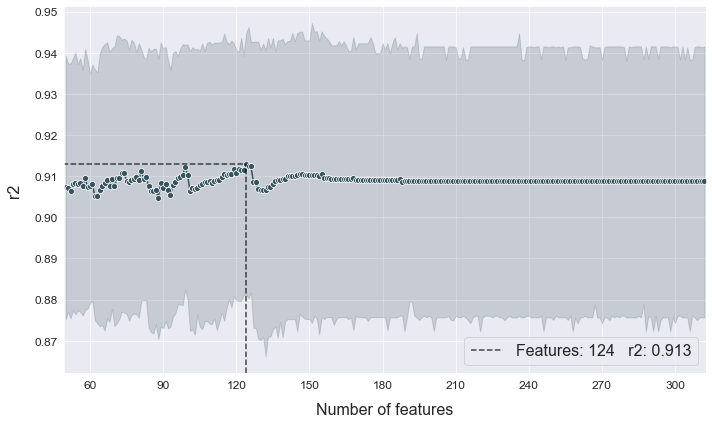

In [90]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [93]:
#atom.plot_pca(filename="pca",figsize=(8,5)) 
#error: not available because pca is not applied on the data. 

In [94]:
#how to review all the selected features?

In [95]:
# see how the LGB performs after the rigorous feature selection 
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: r2


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> r2: 0.995
Test evaluation --> r2: 0.9502
Time elapsed: 0.238s
-------------------------------------------------
Total time: 0.239s


Final results ==================== >>
Duration: 0.244s
-------------------------------------
LightGBM --> r2: 0.9502


# model fitting after dfs selection 

In [178]:
#run rest of the other combiation of models 
atom.run(
    models=["Ridge_dfs","Lasso_dfs","EN_dfs","Lars_dfs","BR_dfs","Huber_dfs", "KNN_dfs", "RF_dfs","AdaB_dfs","GBM_dfs","hGBM_dfs", "XGB_dfs", "LGB_dfs", "CatB_dfs", "lSVM_dfs", "kSVM_dfs", "PA_dfs", "SGD_dfs", "MLP_dfs", "Tree_dfs","Bag_dfs","ET_dfs"], #EN: elastic net # would KNN work? 
    metric=["R2"],
    n_calls=5, #?
    n_initial_points=2, #?
    bo_params={"base_estimator": "GBRT"},
    n_bootstrap=5,
)

#Choose from: Dummy, GP, GNB, MNB, BNB, CatNB, CNB, OLS, Ridge, Lasso, EN, Lars, BR, ARD, Huber, Perc, LR, LDA, QDA, KNN, RNN, Tree, Bag, ET, RF, AdaB, GBM, hGBM, XGB, LGB, CatB, lSVM, kSVM, PA, SGD, MLP.


Training ========================= >>
Models: Ridge_dfs, Lasso_dfs, EN_dfs, Lars_dfs, BR_dfs, Huber_dfs, KNN_dfs, RF_dfs, AdaB_dfs, GBM_dfs, hGBM_dfs, XGB_dfs, LGB_dfs, CatB_dfs, lSVM_dfs, kSVM_dfs, PA_dfs, SGD_dfs, MLP_dfs, Tree_dfs, Bag_dfs, ET_dfs
Metric: r2


Running BO for Ridge Estimator...
| call             |   alpha |  solver |      r2 | best_r2 |    time | total_time |
| ---------------- | ------- | ------- | ------- | ------- | ------- | ---------- |
| Initial point 1  |  0.0315 |    saga |  0.6713 |  0.6713 |  0.741s |     0.884s |
| Initial point 2  |  0.8472 | spars.. |    0.79 |    0.79 |  0.385s |     1.276s |
| Iteration 3      |  2.9154 | spars.. |  0.6888 |    0.79 |  0.376s |     1.945s |
| Iteration 4      |  0.9001 | spars.. |  0.6724 |    0.79 |  0.345s |     2.579s |
| Iteration 5      |  0.2089 | spars.. |  0.8583 |  0.8583 |  0.351s |     3.212s |
Bayesian Optimization ---------------------------
Best call --> Iteration 5
Best parameters --> {'alpha': 0.2089,

# Genetic Feature Generation (using atom)

In [117]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfggg"

New branch gfggg successfully created.


In [118]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=10)
#symbolic transformer used. 

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.08         0.187517        3         0.878791              N/A     26.07s
   1     3.30         0.682837        5         0.880719              N/A     35.30s
   2     1.89         0.846492        5         0.880719              N/A     26.43s
   3     1.01         0.871189        1         0.876926              N/A     29.76s
   4     1.02         0.869155        1         0.876926              N/A     22.45s
   5     1.01         0.872942        1         0.876926              N/A     20.91s
   6     1.02          0.86984        1         0.876926              N/A     21.41s
   7     1.01         0.870864        1         0.876926              N/A     23.11s
   8     1.01         0.872885        1        

In [114]:
# view the feature's fitness and description through the genetic_features attribute
print(atom.genetic_features)

None


In [107]:
# Fit the model again
atom.run("LGB_gfg")



Training ========================= >>
Models: LGB_gfg
Metric: r2


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> r2: 0.9783
Test evaluation --> r2: 0.9302
Time elapsed: 0.102s
-------------------------------------------------
Total time: 0.102s


Final results ==================== >>
Duration: 0.103s
-------------------------------------
LightGBM --> r2: 0.9302


Analyze Results (Use atom's plots to compare the three models)

In [108]:
atom.palette = "Paired"
# atom.plot_roc(dataset="both") #plot_roc -- Receiver Operating Characteristics curve (ROC) --> this is for binary classification only. 
atom.reset_aesthetics()

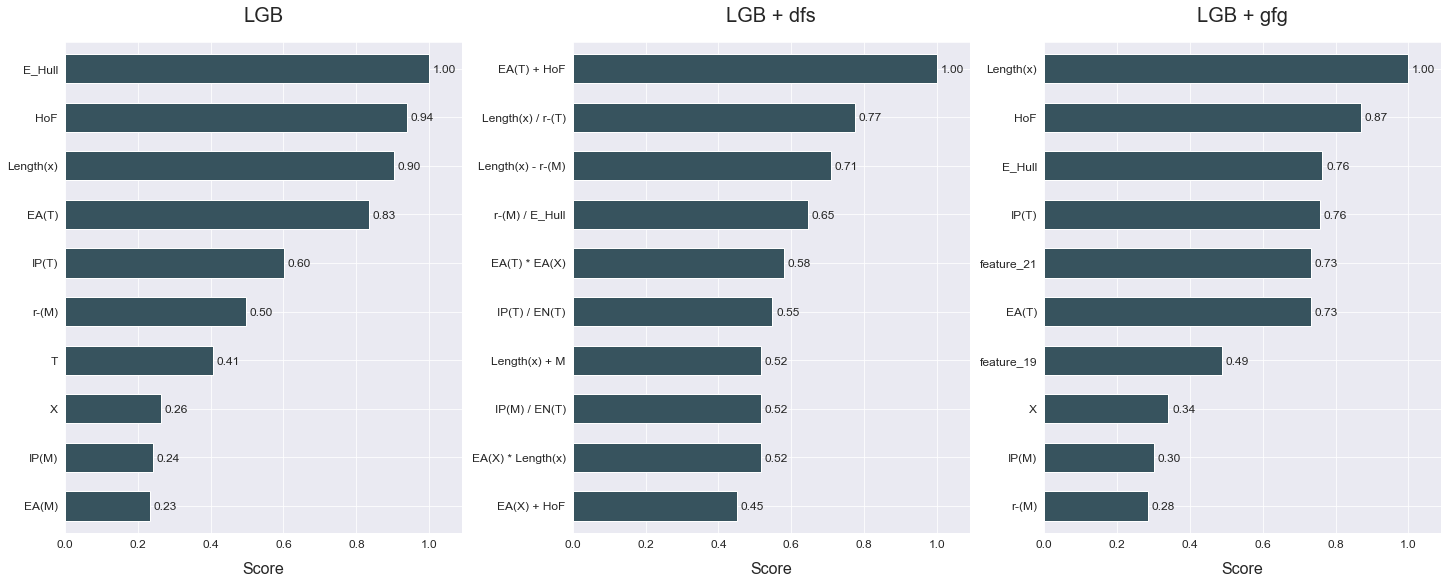

In [109]:

# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + gfg")

    ##look carefully on the labels 

In [110]:
# We can check the feature importance with other plots as well
#atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=10)

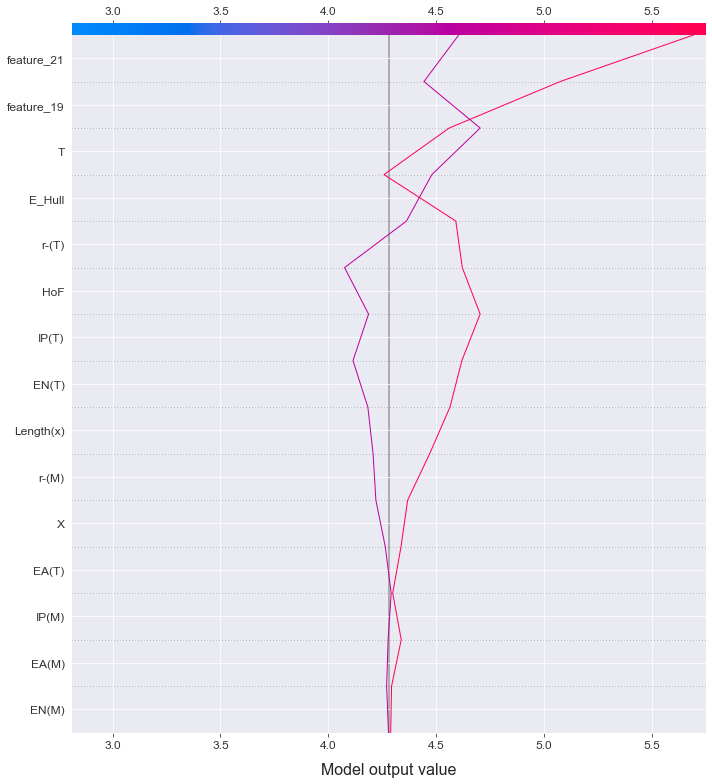

In [111]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)

try saving the feature engineering results to another csv file, and perform the standard machine learning model with it. 

CURRENT PROBLEMS 

 but these don't make sense,  cannot add those with different units. 
 is formula etc involved? (as classification data)- then how is it encoded 
 do we need to set the y value? (workfunction)

# Genetic Feature Generation (using gplearn)

In [157]:
gp= SymbolicTransformer()

In [168]:
X_adjusted = pd.read_csv("AdjustedData.csv")
X_adjusted2 = X_adjusted.drop(['M','X','T','Workfunction','Formula'],axis=1)



In [172]:
X_adjusted.head()

,Formula,M,X,T,Workfunction,HoF,E_Hull,Length(x),r-(M),r-(X),r-(T),IP(M),IP(X),IP(T),EN(M),EN(X),EN(T),EA(M),EA(X),EA(T)
0,Hf3C2H2O2,Hf,C,OH,2.271378,-1.345952,0.242880,330.4,82.9,59.6,41.4,6.8250,11.2603,13.017,1.30,2.55,2.82,0.178,1.262,1.827
1,Sc3C2H2O2,Sc,C,OH,1.588009,-1.199954,0.452744,335.0,53.9,59.6,41.4,6.5614,11.2603,13.017,1.36,2.55,2.82,0.189,1.262,1.827
2,W3C2H2O2,W,C,OH,2.209840,-0.317344,0.473693,290.6,74.6,59.6,41.4,7.9800,11.2603,13.017,2.36,2.55,2.82,0.816,1.262,1.827
3,Mo3H2N2O2,Mo,N,OH,2.463148,-0.594739,0.327053,285.0,70.2,48.8,41.4,7.0942,14.5341,13.017,2.16,3.04,2.82,0.749,-0.070,1.827
4,Ti3H2N2O2,Ti,N,OH,2.329750,-1.597694,0.163033,298.9,48.9,48.8,41.4,6.8282,14.5341,13.017,1.54,3.04,2.82,0.087,-0.070,1.827


In [171]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
                
function_set=[]
gp.fit(X_adjusted2,X_adjusted["Workfunction"]) 


SymbolicTransformer()

# PCA reduction (work in progress) 

In [ ]:
#what exactly does this PCA do (dimensionality reduction), im not very sure 

#dimensionality reduction: reduce size of data by extracting relevant information and removing rest as noise. 

#before, always do mean normalization. can do feature scaling afterwards too 

In [ ]:
atom.columns

Index(['M', 'X', 'T', 'HoF', 'E_Hull', 'Length(x)', 'r-(M)', 'r-(X)', 'r-(T)',
       'IP(M)', 'IP(X)', 'IP(T)', 'EN(M)', 'EN(X)', 'EN(T)', 'EA(M)', 'EA(X)',
       'EA(T)', 'Workfunction'],
      dtype='object')

In [ ]:
atom.feature_selection(strategy="pca",n_features=6)

PermissionError: It's not allowed to add transformers to the branch after it has been used to train models. Create a new branch to continue the pipeline.

In [ ]:
atom.plot_pca()

PermissionError: The plot_pca method is only available if pca was applied on the data!

# Running the regression pipeline 

In [ ]:
atom.run(
    models=["Tree","Bag","ET"],
    metric=["R2"],
    n_calls=5, #?
    n_initial_points=2, #?
    bo_params={"base_estimator": "GBRT"},
    n_bootstrap=5,
)

#i think this is not using the selected feature though. 


Training ========================= >>
Models: Tree, Bag, ET
Metric: r2


Running BO for Decision Tree...
| call             |   criterion | splitter | max_depth | min_samples_split | min_samples_leaf | max_features | ccp_alpha |      r2 | best_r2 |    time | total_time |
| ---------------- | ----------- | -------- | --------- | ----------------- | ---------------- | ------------ | --------- | ------- | ------- | ------- | ---------- |
| Initial point 1  | absolute_.. |   random |        12 |                 8 |               19 |         auto |    0.0161 |  0.6315 |  0.6315 |  0.321s |     0.656s |
| Initial point 2  | absolute_.. |     best |        11 |                 3 |               12 |         None |       0.0 |  0.9009 |  0.9009 |  0.166s |     0.831s |
| Iteration 3      | absolute_.. |     best |        11 |                 4 |                1 |         None |    0.0086 |  0.8025 |  0.9009 |  0.146s |     1.349s |
| Iteration 4      | absolute_.. |   random |        12 |  

In [ ]:
atom.plot_residuals()

AttributeError: ATOMRegressor object has no attribute name.

In [ ]:
atom.plot_errors()

AttributeError: ATOMRegressor object has no attribute name.

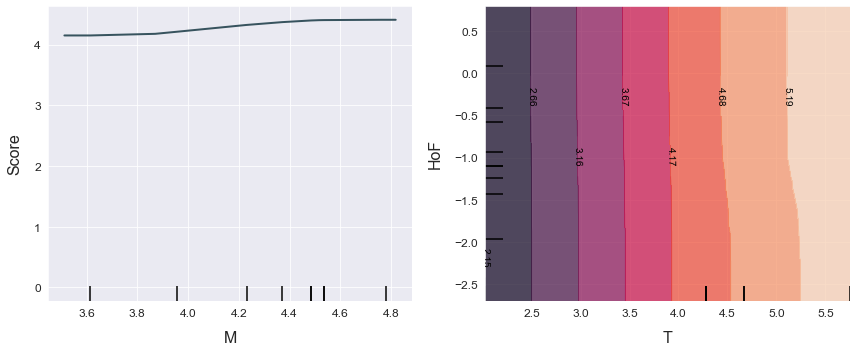

In [ ]:
#relation between target response and features 
atom.n_jobs = 8
atom.ET.plot_partial_dependence(columns=(0, (2,3)),figsize=(12,5))
#why HoF and T? 